In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import matplotlib.pyplot as plt

In [2]:
data = 'data'

In [3]:
# sets = os.listdir(data)
# class_names = os.listdir(os.path.join(data,sets[0]))
# class_paths = [os.path.join(data, cls) for cls in class_names]

In [4]:
# file_paths = []
# labels = []

In [5]:
# for idx, class_path in enumerate(class_paths):
#     files = os.listdir(class_path)
#     file_paths.extend([os.path.join(class_path, file) for file in files])
#     labels.extend([idx] * len(files))

In [6]:
# np.array(labels).shape

In [7]:
# Split the data into train and test sets
# train_files, test_files, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

In [8]:
# Define the EfficientNetV2 model from TensorFlow Hub
efficientnetv2_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2'
efficientnetv2 = hub.KerasLayer(efficientnetv2_url,
                                trainable=True,)

In [9]:
# Define data augmentation for both training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # shear_range=0.2,
    zoom_range=0.3,
    brightness_range= (0.8,1.0),
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    rotation_range = 30,
    horizontal_flip=True,
    vertical_flip=True
    # validation_split=0.2  # 20% validation split
)
val_datagen= ImageDataGenerator(rescale=1./255)


# Set the target image size
target_size = (384, 384)  # Adjust based on your EfficientNetV2 input size
batch_size = 8

# Create train and validation generators
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=target_size,
    batch_size= batch_size,
    class_mode='categorical',
)

validation_generator = val_datagen.flow_from_directory(
    'data/val',
    target_size=target_size,
    batch_size= batch_size,
    class_mode='categorical',
)

Found 805 images belonging to 10 classes.


Found 201 images belonging to 10 classes.


In [10]:
class_names = [key for key in train_generator.class_indices]

In [11]:
# Create a new model on top of EfficientNetV2
model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(target_size+(3,)))
model.add(efficientnetv2)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(512, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(512, activation = 'relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(512, activation = 'relu'))
# model.add( tf.keras.layers.Dense(64, activation = 'softmax'))
# model.add( tf.keras.layers.Dense(32, activation = 'softmax'))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              20331360  
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                        

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Define early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-9)
es = EarlyStopping(monitor='val_loss', patience=7, mode="min", restore_best_weights=True)

In [15]:
history = model.fit(train_generator, epochs=256, 
                validation_data=validation_generator, 
                verbose=1, 
                callbacks=[es, reduce_lr])

Epoch 1/256
101/101 [==============================] - 52s 324ms/step - loss: 1.6849 - accuracy: 0.4087 - val_loss: 1.4177 - val_accuracy: 0.6517 - lr: 1.0000e-04
Epoch 2/256
101/101 [==============================] - 31s 301ms/step - loss: 0.9443 - accuracy: 0.6422 - val_loss: 0.7126 - val_accuracy: 0.8507 - lr: 1.0000e-04
Epoch 3/256
101/101 [==============================] - 31s 303ms/step - loss: 0.6878 - accuracy: 0.7503 - val_loss: 0.3874 - val_accuracy: 0.8806 - lr: 1.0000e-04
Epoch 4/256
101/101 [==============================] - 31s 306ms/step - loss: 0.5156 - accuracy: 0.8124 - val_loss: 0.2693 - val_accuracy: 0.9204 - lr: 1.0000e-04
Epoch 5/256
101/101 [==============================] - 31s 301ms/step - loss: 0.4622 - accuracy: 0.8385 - val_loss: 0.2131 - val_accuracy: 0.9254 - lr: 1.0000e-04
Epoch 6/256
101/101 [==============================] - 31s 308ms/step - loss: 0.4138 - accuracy: 0.8534 - val_loss: 0.1955 - val_accuracy: 0.9154 - lr: 1.0000e-04
Epoch 7/256
101/101 [=

In [16]:
# es = EarlyStopping(monitor='loss', patience=5, mode="min", restore_best_weights=True)
# history2 = model.fit(train_generator, epochs=16, 
#                 validation_data=validation_generator, 
#                 verbose=1, 
#                 callbacks=[es, reduce_lr])

In [17]:
## General save path
version = len(os.listdir('models'))
save_path = 'models/classifier_v{:d}/'.format(version)
os.mkdir(save_path)

In [18]:
## Best model saved
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

best_epoch = np.argmin(np.array(val_loss))

print("Best Epoch: ", best_epoch)
print("Final Train Loss: {:.4f}".format(train_loss[best_epoch]))
print("Final Validation Loss: {:.4f}".format(val_loss[best_epoch]))
print("Final Train accuracy: {:.2f}".format(train_accuracy[best_epoch]*100))
print("Final Test accuracy: {:.2f}".format(val_accuracy[best_epoch]*100))

Best Epoch:  19
Final Train Loss: 0.1304
Final Validation Loss: 0.1188
Final Train accuracy: 95.65
Final Test accuracy: 96.52


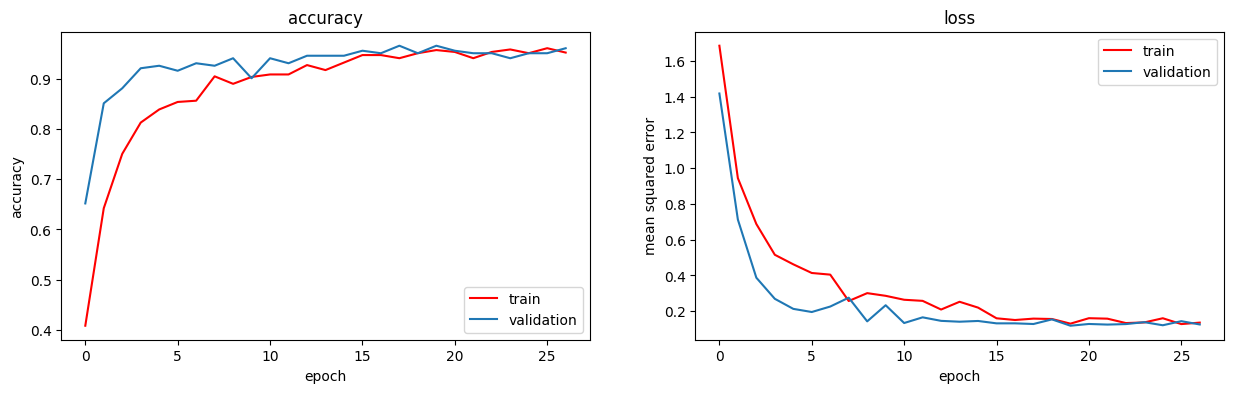

In [19]:
# Saving the figure.
## Graphing Result of training
x_ticks = [i for i in range(len(history.history['loss']))  if i%5==0 ]
plt.figure(figsize=(15,4))

plt.subplot(121)
plt.plot(history.history['accuracy'], color ='r')
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.legend(['train','validation'])
plt.xticks(x_ticks)
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.subplot(122)
plt.plot(history.history['loss'], color ='r')
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend(['train','validation'])
plt.xticks(x_ticks)
plt.xlabel('epoch')
plt.ylabel('mean squared error')

plt.savefig(save_path+"plots.jpg")

In [20]:
## Save best metrics
with open(save_path+'metrics.txt', 'w') as f:
    f.write("Best Epoch: {:d} \n".format(best_epoch))
    f.write("Final Train Loss: {:.4f}\n".format(train_loss[best_epoch]))
    f.write("Final Validation Loss: {:.4f}\n".format(val_loss[best_epoch]))
    f.write("Final Train accuracy: {:.2f}%\n".format(train_accuracy[best_epoch]*100))
    f.write("Final Test accuracy: {:.2f}%\n".format(val_accuracy[best_epoch]*100))

Save the model

In [21]:
## saving model
model.save(save_path+'model.h5')

In [22]:
from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(image_path, target_size):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array *= 1./255
    return img_array

In [23]:
image_path = 'data/train/bacterial_leaf_blight/BLB (13).png'


input_image = load_and_preprocess_image(image_path, target_size=target_size)


predictions = model.predict(input_image)

print(class_names[np.argmax(predictions[0])])
print('probability {:.4f}'.format(predictions[0][np.argmax(predictions[0])]))

1/1 [==============================] - 1s 1s/step
bacterial_leaf_blight
probability 1.0000


In [24]:
image_path = 'data/train/Yellow Stem Borer/4 (3).png'


input_image = load_and_preprocess_image(image_path, target_size=target_size)


predictions = model.predict(input_image)

print(class_names[np.argmax(predictions[0])])
print('probability {:.4f}'.format(predictions[0][np.argmax(predictions[0])]))

1/1 [==============================] - 0s 26ms/step
Yellow Stem Borer
probability 1.0000
